<h1 style="color: red;">📋 News Classifier</h1>


* imports : 

In [19]:
import sys
import os
sys.path.append(os.path.abspath(".."))

from functions.data_loader import load_data
from functions.analyse_exploratoire import repartition_classes, analyse_len_text, plot_wordcloud
from functions.pretraitement_text import preprocess_dataframe
from functions.entrainement import NewsClassifier
from functions.embeddings import EmbeddingManager
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re
import string
from sklearn.linear_model import LogisticRegression




<h2 style="color:#4CAF50;">📌 Partie 1 : Préparation des données</h2>



<h3 style="color:#FF5722;">🔧 Chargement du dataset</h3>


In [2]:

df_train, df_test = load_data()

print(f"Train shape: {df_train.shape}")
print(f"Test shape: {df_test.shape}")
df_train.head()

Loading dataset SetFit/ag_news
Dataset loaded successfully.
Train shape: (120000, 3)
Test shape: (7600, 3)


,text,label,label_text
0,Wall St. Bears Claw Back Into the Black (Reute...,2,Business
1,Carlyle Looks Toward Commercial Aerospace (Reu...,2,Business
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,2,Business
3,Iraq Halts Oil Exports from Main Southern Pipe...,2,Business
4,"Oil prices soar to all-time record, posing new...",2,Business


In [3]:
df_train.columns

Index(['text', 'label', 'label_text'], dtype='object')

In [4]:
print("\nla destribution des labels train : ", df_train['label_text'].value_counts())
print("\nla destribution des labels test : ", df_train['label_text'].value_counts())


la destribution des labels train :  label_text
Business    30000
Sci/Tech    30000
Sports      30000
World       30000
Name: count, dtype: int64

la destribution des labels test :  label_text
Business    30000
Sci/Tech    30000
Sports      30000
World       30000
Name: count, dtype: int64


<h3 style="color:#FF5722;">📊 Analyse exploratoire (EDA)</h3>


* la répartition des classes

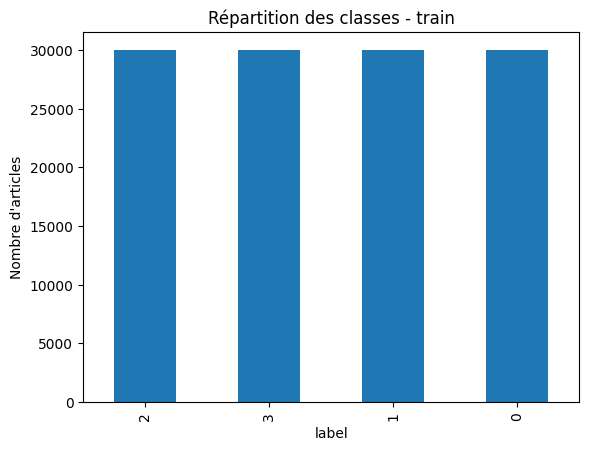

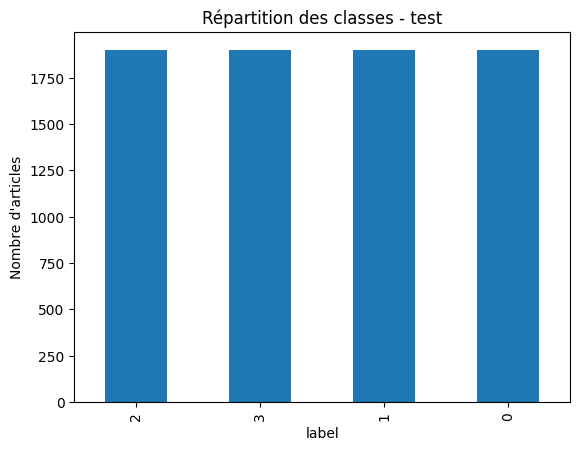

In [5]:
repartition_classes(df_train, "label", "train")
repartition_classes(df_test, "label", "test")


* Analyse des longueurs des textes

****************************************************************************************************
Partie Train : 

                                                text  label label_text  \
0  Wall St. Bears Claw Back Into the Black (Reute...      2   Business   
1  Carlyle Looks Toward Commercial Aerospace (Reu...      2   Business   
2  Oil and Economy Cloud Stocks' Outlook (Reuters...      2   Business   
3  Iraq Halts Oil Exports from Main Southern Pipe...      2   Business   
4  Oil prices soar to all-time record, posing new...      2   Business   

   text_length  
0          144  
1          266  
2          232  
3          256  
4          234  
 count    120000.000000
mean        236.477525
std          66.509741
min         100.000000
25%         196.000000
50%         232.000000
75%         266.000000
max        1012.000000
Name: text_length, dtype: float64


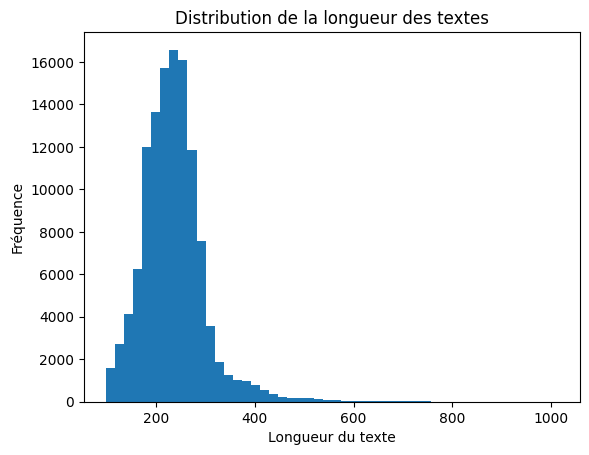

In [6]:
print("****"*25)
print("Partie Train : \n")
analyse_len_text(df_train, "text")

****************************************************************************************************
Partie Test : 

                                                text  label label_text  \
0  Fears for T N pension after talks Unions repre...      2   Business   
1  The Race is On: Second Private Team Sets Launc...      3   Sci/Tech   
2  Ky. Company Wins Grant to Study Peptides (AP) ...      3   Sci/Tech   
3  Prediction Unit Helps Forecast Wildfires (AP) ...      3   Sci/Tech   
4  Calif. Aims to Limit Farm-Related Smog (AP) AP...      3   Sci/Tech   

   text_length  
0          161  
1          321  
2          260  
3          318  
4          223  
 count    7600.000000
mean      235.299211
std        65.302023
min       100.000000
25%       196.750000
50%       231.000000
75%       266.000000
max       892.000000
Name: text_length, dtype: float64


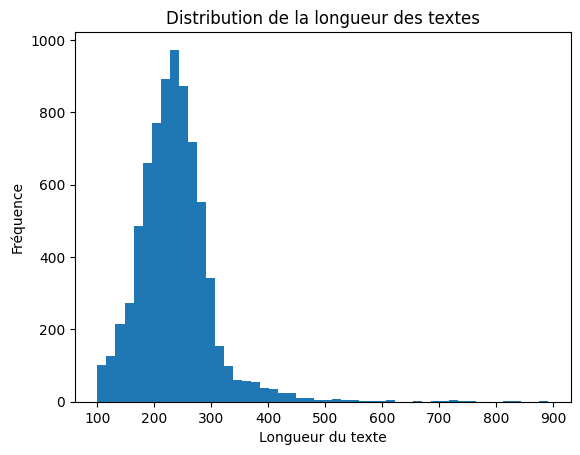

In [7]:
print("****"*25)
print("Partie Test : \n")
analyse_len_text(df_test, "text")

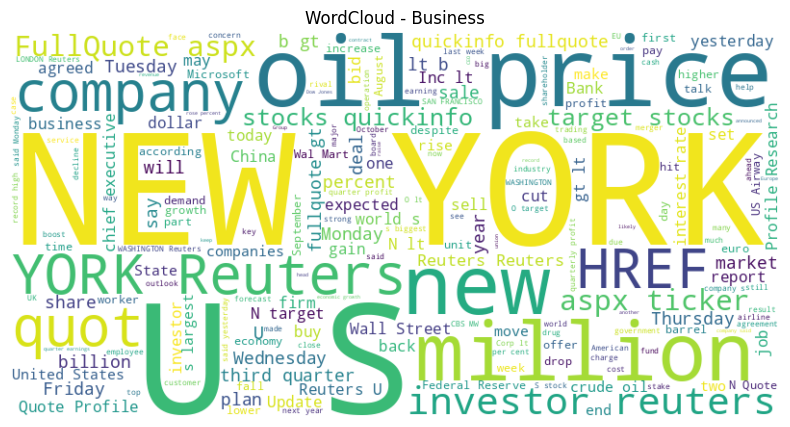

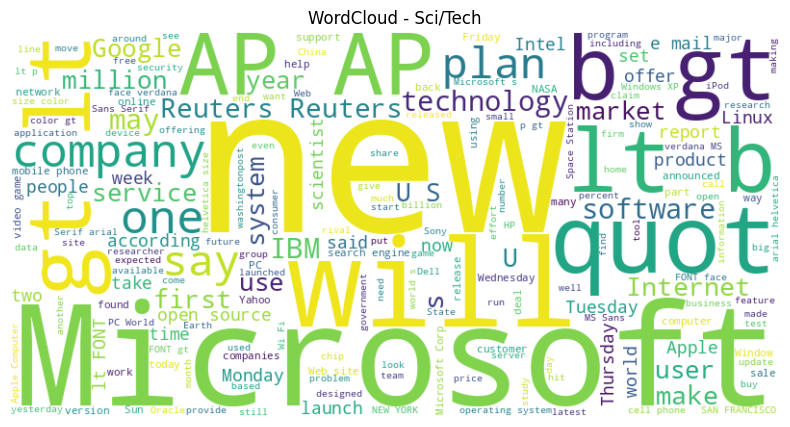

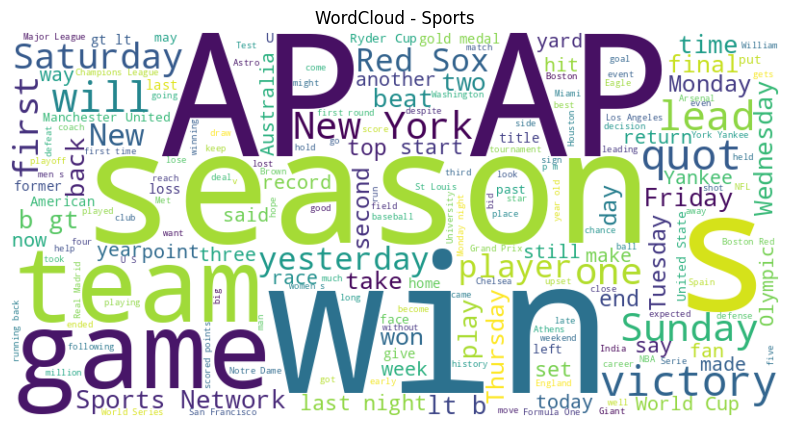

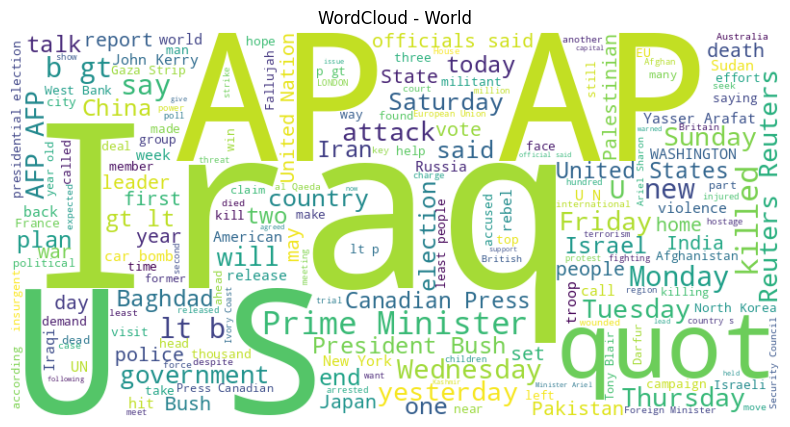

In [8]:


labels_map = df_train["label_text"].unique()

for label_id, label_name in enumerate(labels_map):

    category_texts = df_train[df_train['label_text'] == label_name]['text'].astype(str)

    text_combined = " ".join(category_texts.tolist())

    plot_wordcloud(text_combined, f"WordCloud - {label_name}")


***

<h2 style="color:#4CAF50;">📌 Partie 2 : Prétraitement NLP</h2>

<h3 style="color:#FF5722;">🔧 Nettoyage des textes</h3>

In [9]:
train_df = preprocess_dataframe(df_train, text_column='text')
test_df = preprocess_dataframe(df_test, text_column='text')
    

In [10]:
train_df.head(5)

,text,label,label_text,text_length,clean_text,text_tokenized,text_no_stopwords
0,Wall St. Bears Claw Back Into the Black (Reute...,2,Business,144,wall st bears claw back into the black reuters...,"[wall, st, bears, claw, back, into, the, black...","[wall, st, bears, claw, back, black, reuters, ..."
1,Carlyle Looks Toward Commercial Aerospace (Reu...,2,Business,266,carlyle looks toward commercial aerospace reut...,"[carlyle, looks, toward, commercial, aerospace...","[carlyle, looks, toward, commercial, aerospace..."
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,2,Business,232,oil and economy cloud stocks outlook reuters r...,"[oil, and, economy, cloud, stocks, outlook, re...","[oil, economy, cloud, stocks, outlook, reuters..."
3,Iraq Halts Oil Exports from Main Southern Pipe...,2,Business,256,iraq halts oil exports from main southern pipe...,"[iraq, halts, oil, exports, from, main, southe...","[iraq, halts, oil, exports, main, southern, pi..."
4,"Oil prices soar to all-time record, posing new...",2,Business,234,oil prices soar to alltime record posing new m...,"[oil, prices, soar, to, alltime, record, posin...","[oil, prices, soar, alltime, record, posing, n..."


In [11]:
test_df.head(5)

,text,label,label_text,text_length,clean_text,text_tokenized,text_no_stopwords
0,Fears for T N pension after talks Unions repre...,2,Business,161,fears for t n pension after talks unions repre...,"[fears, for, t, n, pension, after, talks, unio...","[fears, n, pension, talks, unions, representin..."
1,The Race is On: Second Private Team Sets Launc...,3,Sci/Tech,321,the race is on second private team sets launch...,"[the, race, is, on, second, private, team, set...","[race, second, private, team, sets, launch, da..."
2,Ky. Company Wins Grant to Study Peptides (AP) ...,3,Sci/Tech,260,ky company wins grant to study peptides ap ap ...,"[ky, company, wins, grant, to, study, peptides...","[ky, company, wins, grant, study, peptides, ap..."
3,Prediction Unit Helps Forecast Wildfires (AP) ...,3,Sci/Tech,318,prediction unit helps forecast wildfires ap ap...,"[prediction, unit, helps, forecast, wildfires,...","[prediction, unit, helps, forecast, wildfires,..."
4,Calif. Aims to Limit Farm-Related Smog (AP) AP...,3,Sci/Tech,223,calif aims to limit farmrelated smog ap ap sou...,"[calif, aims, to, limit, farmrelated, smog, ap...","[calif, aims, limit, farmrelated, smog, ap, ap..."


<h3 style="color:#FF5722;">🔧 Vérification</h3>

In [12]:
print("data train AVANT Prétraitement :", df_train.shape)
print("data train APRES Prétraitement :", train_df.shape)
print("data test AVANT Prétraitement :", df_test.shape)
print("data test APRES Prétraitement :", test_df.shape)

data train AVANT Prétraitement : (120000, 5)
data train APRES Prétraitement : (120000, 7)
data test AVANT Prétraitement : (7600, 5)
data test APRES Prétraitement : (7600, 7)


<h2 style="color:#4CAF50;">📌 Partie 3 : Embeddings & Vector Store</h2>

<h3 style="color:#FF5722;">1️⃣ Génération des embeddings</h3>

In [13]:
def embedding_func(embedder, df, type="id"):
    
    part_texts = [" ".join(tokens) for tokens in df['text_no_stopwords']]
    part_metadatas = [{'label': int(l)} for l in df['label'].tolist()]
    part_ids = [f"{type}_{i}" for i in range(len(df))]

    embedder.store_embeddings(f"{type}_collection", part_texts, part_metadatas, part_ids, batch_size=1000)
    
    return part_texts


In [14]:

embedder_train = EmbeddingManager(db_path='../data/train/chroma_db')
embedder_test = EmbeddingManager(db_path='../data/test/chroma_db')


print("\nTrain part : ")
train_texts = embedding_func(embedder_train, train_df, type="train")
X_train = embedder_train.generate_embeddings(train_texts)
print("\nTest part : ")
test_texts = embedding_func(embedder_test, test_df, type="test")
X_test = embedder_test.generate_embeddings(test_texts)



Train part : 
Generating embeddings for 120000 documents...
Processing batch 1 / 121
Processing batch 2 / 121
Processing batch 3 / 121
Processing batch 4 / 121
Processing batch 5 / 121
Processing batch 6 / 121
Processing batch 7 / 121
Processing batch 8 / 121
Processing batch 9 / 121
Processing batch 10 / 121
Processing batch 11 / 121
Processing batch 12 / 121
Processing batch 13 / 121
Processing batch 14 / 121
Processing batch 15 / 121
Processing batch 16 / 121
Processing batch 17 / 121
Processing batch 18 / 121
Processing batch 19 / 121
Processing batch 20 / 121
Processing batch 21 / 121
Processing batch 22 / 121
Processing batch 23 / 121
Processing batch 24 / 121
Processing batch 25 / 121
Processing batch 26 / 121
Processing batch 27 / 121
Processing batch 28 / 121
Processing batch 29 / 121
Processing batch 30 / 121
Processing batch 31 / 121
Processing batch 32 / 121
Processing batch 33 / 121
Processing batch 34 / 121
Processing batch 35 / 121
Processing batch 36 / 121
Processing b

* Vérifier la taille de la collection

In [15]:

print("Train : ")
collection_train = embedder_train.get_collection("train_collection")
print("Nombre de documents stockés :", collection_train.count())

print("Test : ")
collection_test = embedder_test.get_collection("test_collection")
print("Nombre de documents stockés :", collection_test.count())

Train : 
Nombre de documents stockés : 120000
Test : 
Nombre de documents stockés : 7600


In [16]:

sample = collection_train.get(
    ids=["train_0", "train_900", "train_100", "train_4441"],
    include=["documents", "metadatas", "embeddings"]
)

for i in range(len(sample['ids'])):
    print(f"ID: {sample['ids'][i]}")
    print(f"Document: {sample['documents'][i]}")
    print(f"Label: {sample['metadatas'][i]['label']}")
    print(f"Embedding length: {len(sample['embeddings'][i])}\n")


ID: train_0
Document: wall st bears claw back black reuters reuters shortsellers wall streets dwindlingband ultracynics seeing green
Label: 2
Embedding length: 384

ID: train_100
Document: comets asteroids planets around nearby star spacecom spacecom nearby star thought harbor comets asteroids appears home planets presumed worlds smaller jupiter could tiny pluto new observations suggest
Label: 3
Embedding length: 384

ID: train_900
Document: haas cink join ryder cup team jay haas became secondoldest player ryder cup team joining stewart cink two captains picks monday us team try regain cup europe next month
Label: 1
Embedding length: 384

ID: train_4441
Document: microsoft patches patch windows xp service pack gets hotfix vpns part neverending process software development
Label: 3
Embedding length: 384



In [17]:

sample = collection_test.get(
    ids=["test_0", "test_900", "test_100", "test_4441"],
    include=["documents", "metadatas", "embeddings"]
)

for i in range(len(sample['ids'])):
    print(f"ID: {sample['ids'][i]}")
    print(f"Document: {sample['documents'][i]}")
    print(f"Label: {sample['metadatas'][i]['label']}")
    print(f"Embedding length: {len(sample['embeddings'][i])}\n")


ID: test_0
Document: fears n pension talks unions representing workers turner newall say disappointed talks stricken parent firm federal mogul
Label: 2
Embedding length: 384

ID: test_100
Document: olympic history india uae indian army major shot way country first ever individual olympic silver medal tuesday event member dubai ruling family became first ever medallist united arab emirates
Label: 1
Embedding length: 384

ID: test_900
Document: minister lee says uncertainty deepens economic lethargy deputy prime minister financeeconomy minister lee hunjai said monday nation current economic lethargy due unsubstantiated uncertainty future turn weakens confidence market players
Label: 2
Embedding length: 384

ID: test_4441
Document: approval expected big cellphone deal federal regulators formally approve cingular wireless billion purchase ampt wireless today company officials briefed matter said weekend
Label: 3
Embedding length: 384



<h2 style="color:#4CAF50;">📌 Partie 4 : Entraînement & Évaluation</h2>

<h3 style="color:#FF5722;">1️⃣ Entraînement des modèles</h3>

In [ ]:
classifier = NewsClassifier(LogisticRegression(max_iter=1000))
classifier.training(X_train, train_df['label'])


Training model LogisticRegression(max_iter=1000)...
Training complete.

 ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Evaluating model LogisticRegression(max_iter=1000)...
Accuracy: 0.883421052631579
Precision: 0.8834941400810926
Recall: 0.883421052631579
F1_Score: 0.8833977641319749
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.88      0.89      1900
           1       0.94      0.95      0.95      1900
           2       0.83      0.84      0.84      1900
           3       0.86      0.86      0.86      1900

    accuracy                           0.88      7600
   macro avg       0.88      0.88      0.88      7600
weighted avg       0.88      0.88      0.88      7600



(0.883421052631579, 0.8834941400810926, 0.883421052631579, 0.8833977641319749)